<center>

<img src='https://micro.ce.sharif.edu/lib/tpl/writr/images/logo.svg' alt="SUT logo" width=500 height=300 align=center class="saturate" >


<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
Machine Learning <br>
Course Project, Fall 2025 <br>
<font color=3C99D size=5>
EEG - Motor Imagery Classification <br>
<font color=3C99D size=6>
By: Mohammad Hossein Hosseinzadeh 403203557 , Farshad Vaziri 403206179
Group:  G45

<br>
<br>
<br>

</center>

# Motor Imagery Classification

پیاده‌سازی کامل یک پایپلاین طبقه‌بندی *Motor Imagery*

- **فیلترگذاری باندگذر EEG**
- **استخراج ویژگی با CSP**
- **طبقه‌بندی با SVM (RBF)، LDA، KNN، Random Forest**
- **ارزیابی با Accuracy, Precision, Recall, F1, AUC**
- **تحلیل K-means روی فضای ویژگی CSP**

دیتاست هدف: **BCI Competition IV (BCICIV_calib_ds1a, BCICIV_calib_ds1c)**  


In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt
from scipy.optimize import minimize
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, silhouette_samples
)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

np.random.seed(0)


In [2]:
def load_and_window_data(mat_file, scale_factor=0.1):
    """
    معادل MATLAB: load_and_window_data.m
    خروجی:
        windows: [trials, time, channels]
        labels:  [trials]
        fs:      sampling rate
        chNames: channel names
    """
    data = sio.loadmat(mat_file, squeeze_me=True, struct_as_record=False)
    
    cnt = scale_factor * data['cnt'].astype(float)  # [time x channels]
    mrk = data['mrk']
    nfo = data['nfo']
    
    fs = float(nfo.fs)
    chNames = list(nfo.clab)
    
    win_duration = 4.0  # seconds
    win_samples = int(round(win_duration * fs))
    
    cue_pos = mrk.pos
    cue_labels = mrk.y
    num_cues = len(cue_pos)
    
    num_channels = cnt.shape[1]
    windows = np.zeros((num_cues, win_samples, num_channels))
    labels = np.zeros(num_cues, dtype=int)
    
    for i in range(num_cues):
        start_idx = int(cue_pos[i])
        end_idx = start_idx + win_samples
        
        if end_idx > cnt.shape[0]:
            segment = cnt[start_idx:, :]
            padded = np.zeros((win_samples, num_channels))
            padded[:segment.shape[0], :] = segment
            windows[i, :, :] = padded
        else:
            windows[i, :, :] = cnt[start_idx:end_idx, :]
        
        labels[i] = int(cue_labels[i])
    
    return windows, labels, fs, chNames


In [3]:
def bandpass_filter_eeg(windows, fs, low_cut, high_cut, order=4):
    """
    معادل MATLAB: bandpass_filter_eeg.m
    windows: [trials, time, channels]
    """
    num_trials, num_samples, num_channels = windows.shape
    b, a = butter(order, [low_cut, high_cut], btype='bandpass', fs=fs)
    
    windows_filt = np.zeros_like(windows)
    for tr in range(num_trials):
        for ch in range(num_channels):
            sig = windows[tr, :, ch]
            sig_filt = filtfilt(b, a, sig)
            windows_filt[tr, :, ch] = sig_filt
    return windows_filt


In [4]:
def compute_class_covariance(Xc):
    """
    Xc: [trials, time, channels]
    خروجی: R [channels x channels]
    """
    num_trials, _, num_channels = Xc.shape
    R = np.zeros((num_channels, num_channels))
    for i in range(num_trials):
        Xi = Xc[i, :, :]  # [time x channels]
        Ci = Xi.T @ Xi
        Ci = Ci / np.trace(Ci)
        R += Ci
    R /= num_trials
    return R


def compute_csp(X, y, num_components):
    """
    معادل MATLAB: compute_csp.m
    X: [trials, time, channels]
    y: [trials] با دو کلاس (مثلاً -1 و 1)
    """
    if num_components % 2 != 0:
        raise ValueError("numComponents must be even.")
    
    classes = np.unique(y)
    if len(classes) != 2:
        raise ValueError("CSP is defined for two classes only.")
    
    class1, class2 = classes[0], classes[1]
    
    R1 = compute_class_covariance(X[y == class1])
    R2 = compute_class_covariance(X[y == class2])
    R = R1 + R2
    
    # generalized eigenvalue problem: R1 w = λ R w
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(R) @ R1)
    idx = np.argsort(eigvals)[::-1]
    E = eigvecs[:, idx]
    
    m = num_components // 2
    W = np.concatenate([E[:, :m], E[:, -m:]], axis=1)
    return W


def extract_csp_features(X, W):
    """
    معادل MATLAB: extract_csp_features.m
    X: [trials, time, channels]
    W: [channels, num_components]
    خروجی: [trials, num_components]
    """
    num_trials = X.shape[0]
    num_components = W.shape[1]
    features = np.zeros((num_trials, num_components))
    
    for i in range(num_trials):
        Xi = X[i, :, :]  # [time x channels]
        Z = Xi @ W       # [time x num_components]
        varZ = np.var(Z, axis=0, ddof=1)
        features[i, :] = np.log(varZ / np.sum(varZ))
    return features


In [5]:
def rbf_kernel(X1, X2, gamma):
    X1_sq = np.sum(X1**2, axis=1, keepdims=True)
    X2_sq = np.sum(X2**2, axis=1, keepdims=True).T
    dist_sq = X1_sq + X2_sq - 2 * (X1 @ X2.T)
    return np.exp(-gamma * dist_sq)


def svm_rbf_train(X, y, C, gamma):
    """
    معادل MATLAB: svm_rbf_train.m
    X: [N, d], y: [N] در { -1, 1 }
    """
    X = X.astype(float)
    y = y.astype(float).reshape(-1)
    N = X.shape[0]
    
    K = rbf_kernel(X, X, gamma)
    H = (y[:, None] * y[None, :]) * K
    f = -np.ones(N)
    
    # تابع هدف برای minimize (1/2 x^T H x + f^T x)
    def obj(alpha):
        return 0.5 * alpha @ H @ alpha + f @ alpha
    
    # گرادیان
    def obj_grad(alpha):
        return H @ alpha + f
    
    # قیود: 0 <= alpha_i <= C, sum(alpha_i y_i) = 0
    cons = {
        'type': 'eq',
        'fun': lambda a: np.dot(a, y),
        'jac': lambda a: y
    }
    bounds = [(0, C) for _ in range(N)]
    
    alpha0 = np.zeros(N)
    res = minimize(obj, alpha0, jac=obj_grad, bounds=bounds, constraints=cons)
    alpha = res.x
    
    sv_idx = np.where(alpha > 1e-6)[0]
    alpha_sv = alpha[sv_idx]
    X_sv = X[sv_idx]
    y_sv = y[sv_idx]
    
    margin_idx = np.where((alpha > 1e-6) & (alpha < C - 1e-6))[0]
    if len(margin_idx) > 0:
        b_vals = []
        for i in margin_idx:
            Ki = K[i, sv_idx]
            b_vals.append(y[i] - np.sum(alpha_sv * y_sv * Ki))
        b = np.mean(b_vals)
    else:
        b_vals = []
        for i in sv_idx:
            Ki = K[i, sv_idx]
            b_vals.append(y[i] - np.sum(alpha_sv * y_sv * Ki))
        b = np.mean(b_vals)
    
    model = {
        'X_sv': X_sv,
        'y_sv': y_sv,
        'alpha_sv': alpha_sv,
        'b': b,
        'gamma': gamma
    }
    return model


def svm_rbf_predict(model, X):
    X = X.astype(float)
    X_sv = model['X_sv']
    y_sv = model['y_sv']
    alpha_sv = model['alpha_sv']
    gamma = model['gamma']
    b = model['b']
    
    K = rbf_kernel(X, X_sv, gamma)
    scores = K @ (alpha_sv * y_sv) + b
    return scores


In [6]:
def tune_svm_rbf(feat_train, y_train):
    C_values = [0.1, 1, 10, 100]
    gamma_values = [0.01, 0.1, 0.5, 1.0]
    
    k_folds = 5
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=0)
    
    best_acc = -np.inf
    best_C = None
    best_gamma = None
    
    for C in C_values:
        for gamma in gamma_values:
            acc_fold = []
            for train_idx, val_idx in cv.split(feat_train, y_train):
                X_tr = feat_train[train_idx]
                y_tr = y_train[train_idx]
                X_val = feat_train[val_idx]
                y_val = y_train[val_idx]
                
                model = svm_rbf_train(X_tr, y_tr, C, gamma)
                scores_val = svm_rbf_predict(model, X_val)
                y_pred_val = np.sign(scores_val)
                y_pred_val[y_pred_val == 0] = 1
                acc_fold.append(np.mean(y_pred_val == y_val))
            mean_acc = np.mean(acc_fold)
            if mean_acc > best_acc:
                best_acc = mean_acc
                best_C = C
                best_gamma = gamma
    
    best_model = svm_rbf_train(feat_train, y_train, best_C, best_gamma)
    return best_model, best_C, best_gamma, best_acc


In [7]:
def tune_knn(feat_train, y_train):
    k_values = [1, 3, 5, 7, 9]
    dist_metrics = ['euclidean', 'manhattan', 'cosine']
    
    k_folds = 5
    best_acc = -np.inf
    best_k = None
    best_dist = None
    
    for dist in dist_metrics:
        for k in k_values:
            knn = KNeighborsClassifier(
                n_neighbors=k,
                metric=dist
            )
            cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=0)
            scores = cross_val_score(knn, feat_train, y_train, cv=cv)
            acc_tmp = np.mean(scores)
            if acc_tmp > best_acc:
                best_acc = acc_tmp
                best_k = k
                best_dist = dist
    
    best_model = KNeighborsClassifier(
        n_neighbors=best_k,
        metric=best_dist
    )
    best_model.fit(feat_train, y_train)
    return best_model, best_k, best_dist, best_acc


def tune_random_forest(feat_train, y_train):
    tree_values = [50, 100, 200]
    leaf_values = [1, 5, 10]
    
    k_folds = 5
    best_acc = -np.inf
    best_trees = None
    best_leaf = None
    
    for nt in tree_values:
        for lf in leaf_values:
            rf = RandomForestClassifier(
                n_estimators=nt,
                min_samples_leaf=lf,
                random_state=0
            )
            cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=0)
            scores = cross_val_score(rf, feat_train, y_train, cv=cv)
            acc_tmp = np.mean(scores)
            if acc_tmp > best_acc:
                best_acc = acc_tmp
                best_trees = nt
                best_leaf = lf
    
    best_model = RandomForestClassifier(
        n_estimators=best_trees,
        min_samples_leaf=best_leaf,
        random_state=0
    )
    best_model.fit(feat_train, y_train)
    return best_model, best_trees, best_leaf, best_acc


In [8]:
def compute_classification_metrics(y_true, y_pred):
    """
    معادل MATLAB: compute_classification_metrics.m
    y_true, y_pred در { -1, 1 }
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    return acc, prec, rec, f1


In [9]:
def evaluate_kmeans_k(X, max_k):
    wcss_values = np.zeros(max_k)
    sil_values = np.zeros(max_k)
    
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
        idx = kmeans.fit_predict(X)
        wcss_values[k-1] = kmeans.inertia_
        
        if k > 1:
            s = silhouette_samples(X, idx)
            sil_values[k-1] = np.mean(s)
        else:
            sil_values[k-1] = np.nan
    return wcss_values, sil_values


def run_kmeans_clustering(X, k):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    idx = kmeans.fit_predict(X)
    C = kmeans.cluster_centers_
    return idx, C


In [10]:
def run_single_file_pipeline(mat_file, low_cut, high_cut, num_csp_components, C, gamma):
    windows, labels, fs, _ = load_and_window_data(mat_file)
    windows_filt = bandpass_filter_eeg(windows, fs, low_cut, high_cut)
    
    num_samples = windows_filt.shape[0]
    idx = np.random.permutation(num_samples)
    train_count = int(round(0.75 * num_samples))
    train_idx = idx[:train_count]
    test_idx = idx[train_count:]
    
    X_train = windows_filt[train_idx]
    y_train = labels[train_idx]
    X_test = windows_filt[test_idx]
    y_test = labels[test_idx]
    
    W_csp = compute_csp(X_train, y_train, num_csp_components)
    feat_train = extract_csp_features(X_train, W_csp)
    feat_test = extract_csp_features(X_test, W_csp)
    
    model = svm_rbf_train(feat_train, y_train, C, gamma)
    scores = svm_rbf_predict(model, feat_test)
    y_pred = np.sign(scores)
    y_pred[y_pred == 0] = 1
    
    acc, _, _, _ = compute_classification_metrics(y_test, y_pred)
    print(f"  -> Accuracy on {mat_file}: {acc:.4f}")
    return acc



In [11]:
# تنظیم پارامترها
dataFile1 = "BCICIV_calib_ds1a.mat"
lowCut = 8
highCut = 30
numCSPComponents = 6

windows1, labels1, fs1, chNames1 = load_and_window_data(dataFile1)
windows1_filt = bandpass_filter_eeg(windows1, fs1, lowCut, highCut)

num_samples1 = windows1_filt.shape[0]
idx1 = np.random.permutation(num_samples1)
train_count1 = int(round(0.75 * num_samples1))
train_idx1 = idx1[:train_count1]
test_idx1 = idx1[train_count1:]

X_train1 = windows1_filt[train_idx1]
y_train1 = labels1[train_idx1]
X_test1 = windows1_filt[test_idx1]
y_test1 = labels1[test_idx1]

W_csp = compute_csp(X_train1, y_train1, numCSPComponents)
feat_train1 = extract_csp_features(X_train1, W_csp)
feat_test1 = extract_csp_features(X_test1, W_csp)

# SVM RBF tuning
print("[Step 5.1] Hyperparameter tuning for SVM-RBF...")
svmModel, C1, gamma1, cvAcc_svm1 = tune_svm_rbf(feat_train1, y_train1)
print(f"  -> Best C = {C1:.4f}, gamma = {gamma1:.4f}, CV-Acc = {cvAcc_svm1:.4f}")

y_scores_svm1 = svm_rbf_predict(svmModel, feat_test1)
y_pred_svm1 = np.sign(y_scores_svm1)
y_pred_svm1[y_pred_svm1 == 0] = 1

acc_svm1, prec_svm1, rec_svm1, f1_svm1 = compute_classification_metrics(y_test1, y_pred_svm1)
fpr_svm1, tpr_svm1, _ = roc_curve(y_test1, y_scores_svm1, pos_label=1)
auc_svm1 = auc(fpr_svm1, tpr_svm1)

print("\n=== SVM-RBF Performance on ds1a ===")
print(f"Accuracy : {acc_svm1:.4f}")
print(f"Precision: {prec_svm1:.4f}")
print(f"Recall   : {rec_svm1:.4f}")
print(f"F1-score : {f1_svm1:.4f}")
print(f"AUC      : {auc_svm1:.4f}")


[Step 5.1] Hyperparameter tuning for SVM-RBF...
  -> Best C = 0.1000, gamma = 0.5000, CV-Acc = 0.9067

=== SVM-RBF Performance on ds1a ===
Accuracy : 0.8600
Precision: 0.9000
Recall   : 0.7826
F1-score : 0.8372
AUC      : 0.9436


In [12]:
def evaluate_model_binary(name, clf, X_train, y_train, X_test, y_test):
    """
    برای مدل‌های اسکیکیت‌لِرن (LDA, KNN, RF)
    """
    clf.fit(X_train, y_train)
    if hasattr(clf, "decision_function"):
        scores = clf.decision_function(X_test)
    else:
        # مثلاً KNN, RF
        proba = clf.predict_proba(X_test)[:, 1]
        scores = proba  # برای ROC
    
    y_pred = clf.predict(X_test)
    acc, prec, rec, f1 = compute_classification_metrics(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, scores, pos_label=1)
    auc_val = auc(fpr, tpr)
    
    print(f"\n=== {name} Performance ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUC      : {auc_val:.4f}")
    
    return {
        "name": name,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "auc": auc_val,
        "fpr": fpr,
        "tpr": tpr
    }


In [13]:
def run_pipeline(mat_file, lowCut=8, highCut=30, numCSPComponents=6):
    print(f"[Dataset] {mat_file}")
    
    # Load & filter
    windows, labels, fs, chNames = load_and_window_data(mat_file)
    windows_filt = bandpass_filter_eeg(windows, fs, lowCut, highCut)

    # Train/test split
    num_samples = windows_filt.shape[0]
    idx = np.random.permutation(num_samples)
    train_count = int(round(0.75 * num_samples))
    train_idx = idx[:train_count]
    test_idx = idx[train_count:]

    X_train = windows_filt[train_idx]
    y_train = labels[train_idx]
    X_test = windows_filt[test_idx]
    y_test = labels[test_idx]

    # CSP
    W_csp = compute_csp(X_train, y_train, numCSPComponents)
    feat_train = extract_csp_features(X_train, W_csp)
    feat_test = extract_csp_features(X_test, W_csp)

    results = []

    # 1) SVM-RBF
    print("\n[Step] SVM-RBF tuning...")
    svmModel, C_best, gamma_best, cvAcc_svm = tune_svm_rbf(feat_train, y_train)
    print(f"  -> Best C = {C_best:.4f}, gamma = {gamma_best:.4f}, CV-Acc = {cvAcc_svm:.4f}")

    y_scores_svm = svm_rbf_predict(svmModel, feat_test)
    y_pred_svm = np.sign(y_scores_svm)
    y_pred_svm[y_pred_svm == 0] = 1

    acc_svm, prec_svm, rec_svm, f1_svm = compute_classification_metrics(y_test, y_pred_svm)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm, pos_label=1)
    auc_svm = auc(fpr_svm, tpr_svm)

    print("\n=== SVM-RBF Performance ===")
    print(f"Accuracy : {acc_svm:.4f}")
    print(f"Precision: {prec_svm:.4f}")
    print(f"Recall   : {rec_svm:.4f}")
    print(f"F1-score : {f1_svm:.4f}")
    print(f"AUC      : {auc_svm:.4f}")

    results.append({
        "name": "SVM-RBF",
        "acc": acc_svm,
        "prec": prec_svm,
        "rec": rec_svm,
        "f1": f1_svm,
        "auc": auc_svm,
        "fpr": fpr_svm,
        "tpr": tpr_svm
    })

    # 2) LDA
    ldaModel = LinearDiscriminantAnalysis()
    res_lda = evaluate_model_binary("LDA", ldaModel, feat_train, y_train, feat_test, y_test)
    results.append(res_lda)

    # 3) KNN
    print("\n[Step] KNN tuning...")
    knnModel, k_best, dist_best, cvAcc_knn = tune_knn(feat_train, y_train)
    print(f"  -> Best k = {k_best}, dist = {dist_best}, CV-Acc = {cvAcc_knn:.4f}")
    res_knn = evaluate_model_binary("KNN", knnModel, feat_train, y_train, feat_test, y_test)
    results.append(res_knn)

    # 4) Random Forest
    print("\n[Step] Random Forest tuning...")
    rfModel, numTrees, bestLeaf, cvAcc_rf = tune_random_forest(feat_train, y_train)
    print(f"  -> Best Trees = {numTrees}, Leaf = {bestLeaf}, CV-Acc = {cvAcc_rf:.4f}")
    res_rf = evaluate_model_binary("Random Forest", rfModel, feat_train, y_train, feat_test, y_test)
    results.append(res_rf)

    return {
        "results": results,
        "W_csp": W_csp,
        "feat_train": feat_train,
        "feat_test": feat_test,
        "y_test": y_test
    }


In [14]:
def plot_roc(results, title):
    plt.figure(figsize=(7, 6))
    for res in results:
        plt.plot(res["fpr"], res["tpr"], label=f'{res["name"]} (AUC={res["auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


[Dataset] BCICIV_calib_ds1a.mat

[Step] SVM-RBF tuning...
  -> Best C = 1.0000, gamma = 0.5000, CV-Acc = 0.8200

=== SVM-RBF Performance ===
Accuracy : 0.7600
Precision: 0.6250
Recall   : 1.0000
F1-score : 0.7692
AUC      : 0.8733

=== LDA Performance ===
Accuracy : 0.7600
Precision: 0.6538
Recall   : 0.8500
F1-score : 0.7391
AUC      : 0.7850

[Step] KNN tuning...
  -> Best k = 7, dist = cosine, CV-Acc = 0.8467

=== KNN Performance ===
Accuracy : 0.7600
Precision: 0.6333
Recall   : 0.9500
F1-score : 0.7600
AUC      : 0.9100

[Step] Random Forest tuning...
  -> Best Trees = 50, Leaf = 5, CV-Acc = 0.8333

=== Random Forest Performance ===
Accuracy : 0.7400
Precision: 0.6296
Recall   : 0.8500
F1-score : 0.7234
AUC      : 0.8450


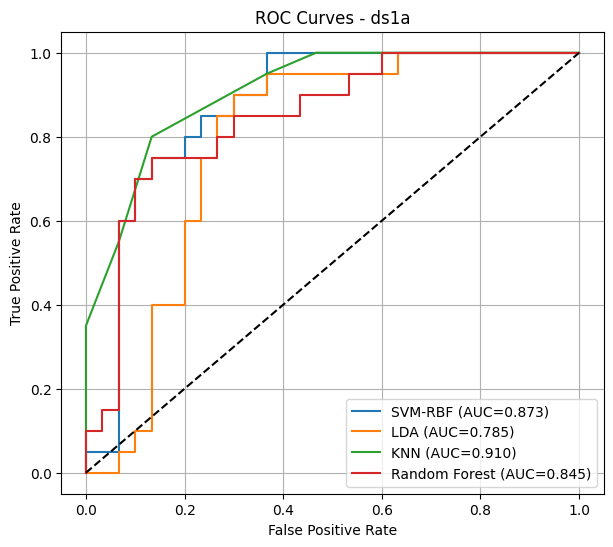

In [15]:
out_a = run_pipeline("BCICIV_calib_ds1a.mat")
plot_roc(out_a["results"], "ROC Curves - ds1a")



[Step] K-means evaluation on ds1a CSP features...


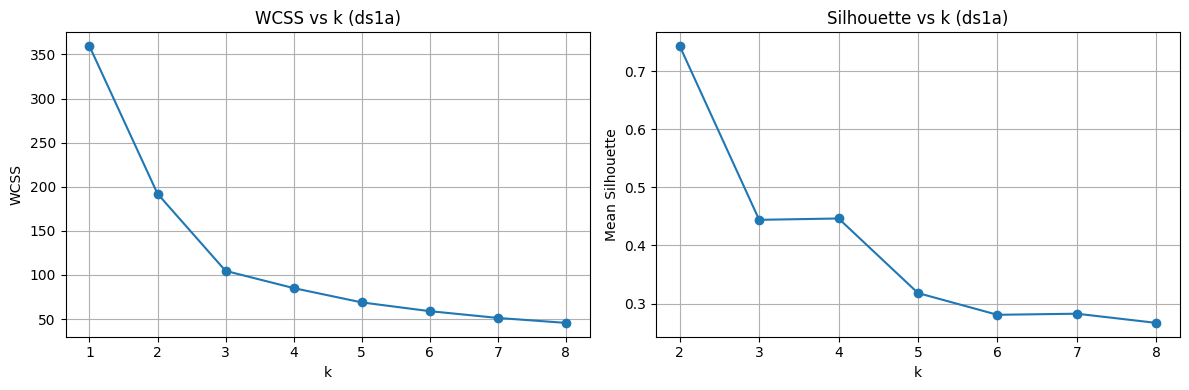

  -> Selected k_opt = 2


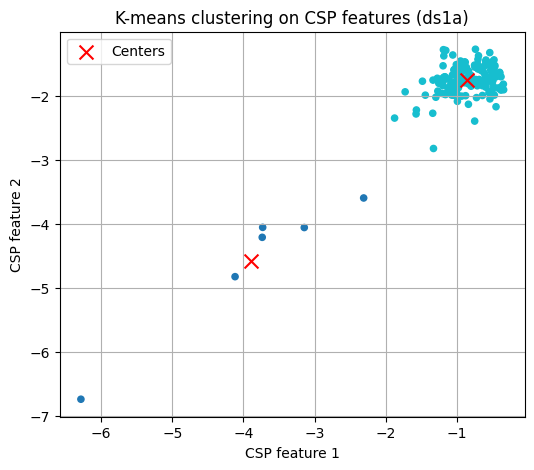

In [16]:
maxK = 8
print("\n[Step] K-means evaluation on ds1a CSP features...")

feat_train_a = out_a["feat_train"]

wcss_values, sil_values = evaluate_kmeans_k(feat_train_a, maxK)

ks = np.arange(1, maxK+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ks, wcss_values, 'o-')
plt.xlabel("k")
plt.ylabel("WCSS")
plt.title("WCSS vs k (ds1a)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ks, sil_values, 'o-')
plt.xlabel("k")
plt.ylabel("Mean Silhouette")
plt.title("Silhouette vs k (ds1a)")
plt.grid(True)

plt.tight_layout()
plt.show()

# انتخاب k_opt (مثلاً بیشترین silhouette برای k>1)
valid_idx = np.where(~np.isnan(sil_values))[0]
k_opt = ks[valid_idx[np.argmax(sil_values[valid_idx])]]
print(f"  -> Selected k_opt = {k_opt}")

idx_kmeans, C_kmeans = run_kmeans_clustering(feat_train_a, k_opt)

plt.figure(figsize=(6, 5))
plt.scatter(feat_train_a[:, 0], feat_train_a[:, 1], c=idx_kmeans, cmap='tab10', s=20)
plt.scatter(C_kmeans[:, 0], C_kmeans[:, 1], c='red', marker='x', s=100, label='Centers')
plt.xlabel("CSP feature 1")
plt.ylabel("CSP feature 2")
plt.title("K-means clustering on CSP features (ds1a)")
plt.legend()
plt.grid(True)
plt.show()


[Dataset] BCICIV_calib_ds1c.mat

[Step] SVM-RBF tuning...
  -> Best C = 0.1000, gamma = 0.5000, CV-Acc = 0.9800

=== SVM-RBF Performance ===
Accuracy : 0.8400
Precision: 0.8148
Recall   : 0.8800
F1-score : 0.8462
AUC      : 0.9520

=== LDA Performance ===
Accuracy : 0.9200
Precision: 0.9200
Recall   : 0.9200
F1-score : 0.9200
AUC      : 0.9280

[Step] KNN tuning...
  -> Best k = 1, dist = euclidean, CV-Acc = 0.9733

=== KNN Performance ===
Accuracy : 0.8200
Precision: 0.8077
Recall   : 0.8400
F1-score : 0.8235
AUC      : 0.8200

[Step] Random Forest tuning...
  -> Best Trees = 100, Leaf = 5, CV-Acc = 0.9667

=== Random Forest Performance ===
Accuracy : 0.8200
Precision: 0.8077
Recall   : 0.8400
F1-score : 0.8235
AUC      : 0.9168


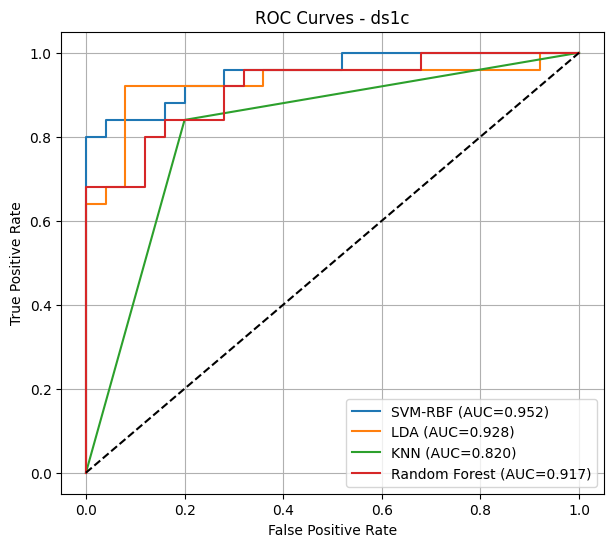

In [17]:
out_c = run_pipeline("BCICIV_calib_ds1c.mat")
plot_roc(out_c["results"], "ROC Curves - ds1c")


In [18]:
import pandas as pd

def get_acc_by_name(results, name_prefix):
    for r in results:
        if r["name"].startswith(name_prefix):
            return r["acc"]
    return np.nan

models = ["SVM-RBF", "LDA", "KNN", "Random Forest"]

rows = []
for mname in models:
    acc_a = get_acc_by_name(out_a["results"], mname)
    acc_c = get_acc_by_name(out_c["results"], mname)
    mean_acc = np.nanmean([acc_a, acc_c])
    rows.append({
        "Model": mname,
        "Acc_ds1a": acc_a,
        "Acc_ds1c": acc_c,
        "MeanAcc": mean_acc
    })

df_results = pd.DataFrame(rows)
print("\n=== Final Accuracy Comparison (ds1a, ds1c) ===")
display(df_results)



=== Final Accuracy Comparison (ds1a, ds1c) ===


,Model,Acc_ds1a,Acc_ds1c,MeanAcc
0,SVM-RBF,0.76,0.84,0.80
1,LDA,0.76,0.92,0.84
2,KNN,0.76,0.82,0.79
3,Random Forest,0.74,0.82,0.78
